In [27]:
import pandas as pd
import numpy as np

### Load the dataset and visualize the relationship between features and labels.

In [28]:
df = pd.read_csv('student_admission_dataset.csv')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GPA                         250 non-null    float64
 1   SAT_Score                   250 non-null    int64  
 2   Extracurricular_Activities  250 non-null    int64  
 3   Admission_Status            250 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 7.9+ KB


In [30]:
df.isnull().sum()

GPA                           0
SAT_Score                     0
Extracurricular_Activities    0
Admission_Status              0
dtype: int64

In [31]:
df.duplicated().sum()

np.int64(0)

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


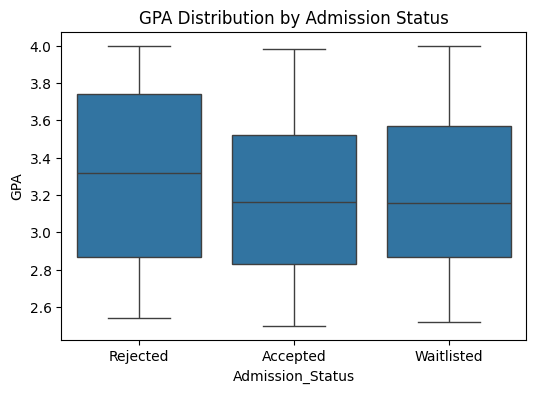

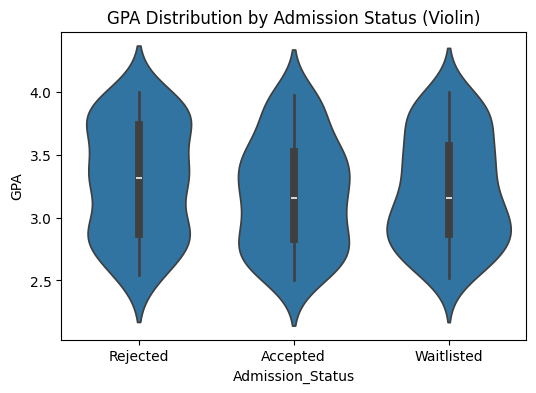

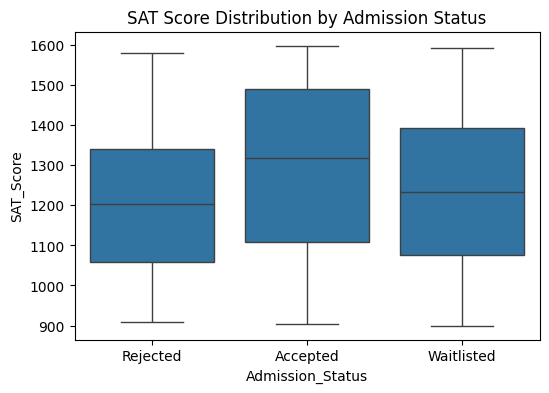

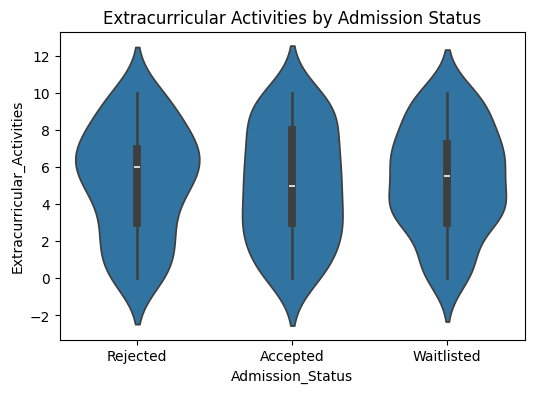

In [33]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Admission_Status", y="GPA", data=df)
plt.title("GPA Distribution by Admission Status")
plt.show()

plt.figure(figsize=(6,4))
sns.violinplot(x="Admission_Status", y="GPA", data=df)
plt.title("GPA Distribution by Admission Status (Violin)")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="Admission_Status", y="SAT_Score", data=df)
plt.title("SAT Score Distribution by Admission Status")
plt.show()

plt.figure(figsize=(6,4))
sns.violinplot(x="Admission_Status", y="Extracurricular_Activities", data=df)
plt.title("Extracurricular Activities by Admission Status")
plt.show()


### Train a logistic regression model.

In [34]:
df

,GPA,SAT_Score,Extracurricular_Activities,Admission_Status
0,3.46,1223,8,Rejected
1,2.54,974,8,Rejected
2,2.91,909,9,Rejected
3,2.83,1369,5,Accepted
4,3.60,1536,7,Accepted
...,...,...,...,...
245,3.57,1024,3,Rejected
246,2.86,1367,1,Waitlisted
247,3.09,1036,3,Waitlisted
248,3.51,1375,5,Waitlisted


In [35]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier


In [36]:
try:
    df
except NameError:
    import pandas as pd
    df = pd.read_csv('student_admission_dataset.csv')


TASK = 'binary'
if df["Admission_Status"].dtype == object:
    raw = df["Admission_Status"].copy()
    mapping = {"Accepted": 1, "Rejected": 0, "Waitlisted": 0}
    df["Admission_Status"] = raw.map(mapping)
    if df["Admission_Status"].isna().any():
        unknown = set(raw[df["Admission_Status"].isna()].unique())
        raise ValueError(f"Unmapped labels: {unknown}")
else:
    if not set(df["Admission_Status"].dropna().unique()).issubset({0, 1}):
        raise ValueError("Numeric labels are not binary {0,1}.")


feature_cols = ["GPA", "SAT_Score", "Extracurricular_Activities"]
X = df[feature_cols]
y = df["Admission_Status"].astype(int)


stratify_col = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_col
)


numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
preprocess = ColumnTransformer([
    ("num", numeric_transformer, feature_cols),
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []


a = Pipeline([
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LogisticRegression(max_iter=3000))
])
param_grid_lr = {
    "model__C": [0.5, 1.0, 2.0, 5.0, 10.0],
    "model__class_weight": [None, "balanced"],
}
search_lr = GridSearchCV(a, param_grid_lr, cv=cv, scoring="accuracy", n_jobs=-1)
search_lr.fit(X_train, y_train)
final_lr = search_lr.best_estimator_
if hasattr(final_lr, "predict_proba") and TASK == 'binary':
    p = final_lr.predict_proba(X_test)[:, 1]
    best_acc = 0
    for t in np.linspace(0.3, 0.7, 41):
        pred = (p >= t).astype(int)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc = acc
    acc_lr = best_acc
else:
    acc_lr = accuracy_score(y_test, final_lr.predict(X_test))
results.append(("LR_poly", acc_lr))


b = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])
param_dist_rf = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
}
search_rf = RandomizedSearchCV(b, param_distributions=param_dist_rf, n_iter=20, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42)
search_rf.fit(X_train, y_train)
final_rf = search_rf.best_estimator_
if hasattr(final_rf, "predict_proba") and TASK == 'binary':
    p = final_rf.predict_proba(X_test)[:, 1]
    best_acc = 0
    for t in np.linspace(0.3, 0.7, 41):
        pred = (p >= t).astype(int)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc = acc
    acc_rf = best_acc
else:
    acc_rf = accuracy_score(y_test, final_rf.predict(X_test))
results.append(("RandomForest", acc_rf))

c = Pipeline([
    ("preprocess", preprocess),
    ("model", HistGradientBoostingClassifier(random_state=42))
])
param_dist_hgb = {
    "model__learning_rate": [0.03, 0.05, 0.1, 0.2],
    "model__max_depth": [None, 3, 5, 7, 10],
    "model__max_leaf_nodes": [15, 31, 63],
    "model__min_samples_leaf": [10, 20, 30],
    "model__l2_regularization": [0.0, 0.1, 1.0, 5.0],
}
search_hgb = RandomizedSearchCV(c, param_distributions=param_dist_hgb, n_iter=25, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42)
search_hgb.fit(X_train, y_train)
final_hgb = search_hgb.best_estimator_
if hasattr(final_hgb, "predict_proba") and TASK == 'binary':
    p = final_hgb.predict_proba(X_test)[:, 1]
    best_acc = 0
    for t in np.linspace(0.3, 0.7, 41):
        pred = (p >= t).astype(int)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc = acc
    acc_hgb = best_acc
else:
    acc_hgb = accuracy_score(y_test, final_hgb.predict(X_test))
results.append(("HistGB", acc_hgb))

best_name, best_acc = max(results, key=lambda x: x[1])

### Plot the decision boundary.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

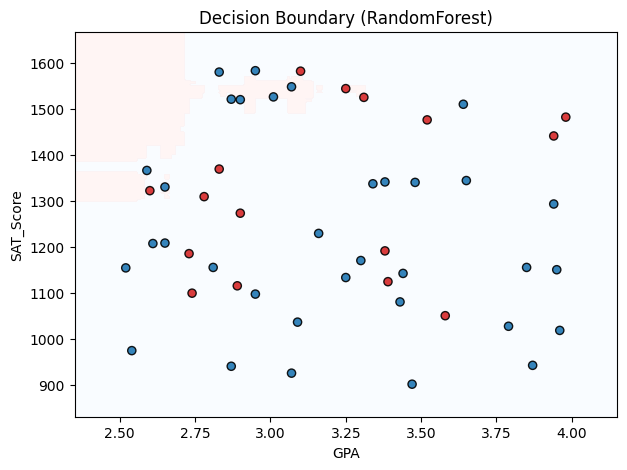

In [38]:
if 'best_name' not in globals():
    raise RuntimeError("Run the modeling cell above first to train and select the best model.")

if best_name == 'LR_poly':
    best_model = final_lr
elif best_name == 'RandomForest':
    best_model = final_rf
else:
    best_model = final_hgb

f1, f2 = 'GPA', 'SAT_Score'
assert f1 in X_train.columns and f2 in X_train.columns

fixed_vals = X_train.median()

pad1 = 0.1 * (X_train[f1].max() - X_train[f1].min() or 1.0)
pad2 = 0.1 * (X_train[f2].max() - X_train[f2].min() or 1.0)
x_min, x_max = X_train[f1].min() - pad1, X_train[f1].max() + pad1
y_min, y_max = X_train[f2].min() - pad2, X_train[f2].max() + pad2
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300),
)

grid = {col: np.full(xx.size, fixed_vals[col]) for col in X_train.columns}
grid[f1] = xx.ravel()
grid[f2] = yy.ravel()
X_grid = pd.DataFrame(grid, columns=X_train.columns)

Z = best_model.predict(X_grid)
Z = Z.reshape(xx.shape)


cmap_bg = ListedColormap(["#f0f8ff", "#ffe4e1"])
plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.35, cmap=cmap_bg, levels=np.arange(Z.max()+2)-0.5)

scatter = plt.scatter(
    X_test[f1], X_test[f2], c=y_test, cmap=ListedColormap(["#1f77b4", "#d62728"]), edgecolor="k", s=35, alpha=0.9
)
plt.xlabel(f1)
plt.ylabel(f2)
plt.title("Decision Boundary (" + best_name + ")")
plt.show()

### Evaluate performance (accuracy, confusion matrix).

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

if 'best_name' not in globals():
    raise RuntimeError("Run the modeling cell above first.")

if best_name == 'LR_poly':
    best_model = final_lr
elif best_name == 'RandomForest':
    best_model = final_rf
else:
    best_model = final_hgb

if hasattr(best_model, 'predict_proba') and TASK == 'binary':
    p = best_model.predict_proba(X_test)[:, 1]
    best_acc, best_t = 0.0, 0.5
    for t in np.linspace(0.3, 0.7, 41):
        pred = (p >= t).astype(int)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc, best_t = acc, t
    y_pred = (p >= best_t).astype(int)
else:
    y_pred = best_model.predict(X_test)


print("accuracy:", accuracy_score(y_test, y_pred))
print("confusion_matrix:\n", confusion_matrix(y_test, y_pred))

accuracy: 0.7
confusion_matrix:
 [[33  1]
 [14  2]]
